In [1]:
import numpy as np
import os
import shutil
from environment.env import SpatialKuramoto
from environment.utils import generate_w0_with_locus

from stable_baselines3 import PPO, SAC, DDPG
from stable_baselines3.common.callbacks import CallbackList, CheckpointCallback
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from aDBS_RL.agents.custom_callbacks import TensorboardCallback, EvalCallback_
from stable_baselines3.common.env_checker import check_env

from environment.env_configs.env0 import (
    n_neurons, grid_size, coord_modif,
    params_dict_train, eval_envs_list,
)

### 1. Set main parameters for training and create folders

In [2]:
exp_name = 'PPO_training'
reward = 'bbpow_action'
save_freq = 50_000  # period of model weights saving
model_name = 'best_ppo_adbs'  # model name for saving

env_eval_num = 3
eval_episodes_num = 3  # how many episodes to run
eval_freq = 50_000
num_steps = 500_000  # for how many steps we train RL aDBS agent 

In [3]:
# Create directory for experiment (for imgs, csv, model.tf, etc.)
MAIN_DIR = 'data/validation_results'
dir = os.path.join(MAIN_DIR, exp_name)

if os.path.exists(dir): 
    shutil.rmtree(dir)
    print('Folder existed. Deleted it!')

os.makedirs(dir) 
save_models_dir = os.path.join(dir, 'saved_models')  # for saving model
os.makedirs(save_models_dir) 
eval_dir = os.path.join(dir, 'eval_results') # for saving evaluation results
os.makedirs(eval_dir) 

# Create csv for the experiment logging
csv_name = os.path.join(dir, f'{exp_name}_stats.csv')
if os.path.isfile(csv_name):
    raise FileExistsError(f'{csv_name} already exist! Use other name')
else:
    with open(csv_name, "w") as f:
        pass

# Create folder to save temporal events
params_dict_train['log_path'] = os.path.join(dir, 'train_events')
if params_dict_train['save_events'] and params_dict_train['log_path'] is not None:
    os.makedirs(params_dict_train['log_path'], exist_ok=True)

Folder existed. Deleted it!


### 2. Instantiate the environment for training

In [4]:
def make_env(d):
    """
    Creates environment for eval
    """
    def _init():
        env = Monitor(SpatialKuramoto(params_dict=d),
                      filename=None)
        return env
    return _init

In [5]:
# Define natural freqs. of neurons 
(w0, ncoords, ngrid,
    w0_temp_, w_locus, lmask) = generate_w0_with_locus(
            n_neurons, grid_size, coord_modif,
            locus_center=params_dict_train['locus_center'],
            locus_size=params_dict_train['locus_size'],
            wmuL=params_dict_train['wmuL'],
            wsdL=params_dict_train['wsdL'],
            show=False, vertical_layer=4)

# Instantiate the env and check
params_dict_train['w0'] = w0
params_dict_train['w0_without_locus'] = w0_temp_
params_dict_train['locus_without_w0'] = w_locus
params_dict_train['locus_mask'] = lmask

params_dict_train['neur_coords'] = ncoords
params_dict_train['neur_grid'] = ngrid
params_dict_train['reward_func'] = reward

env = SpatialKuramoto(params_dict=params_dict_train)

check_env(env)
print('Checked env! Now you can starting train')

No temporal drift events!


DBS affects 512 neurons, min=0.307 & max=1.0
DBS affects 512 neurons, min=0.307 & max=1.0


/home/ekuzmina/miniforge3/envs/kur11/lib/python3.11/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


DBS affects 512 neurons, min=0.307 & max=1.0
DBS affects 512 neurons, min=0.307 & max=1.0
Checked env! Now you can starting train


### 3. Define callbacks and evaluation environments

***Instantiate environments for evaluation***


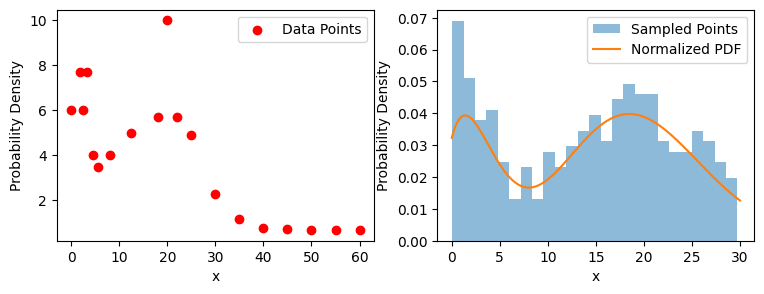

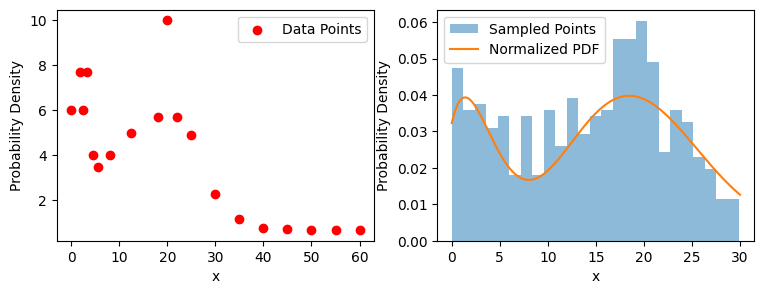

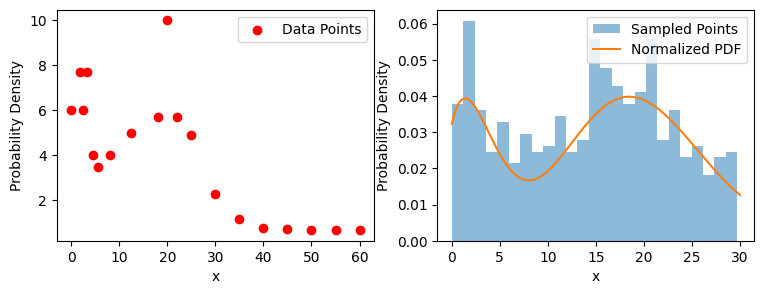

No temporal drift events!
DBS affects 512 neurons, min=0.307 & max=1.0
No temporal drift events!
DBS affects 512 neurons, min=0.307 & max=1.0
No temporal drift events!
DBS affects 512 neurons, min=0.307 & max=1.0


In [6]:
checkpoint_callback = CheckpointCallback(
                        save_freq=save_freq,
                        save_path=save_models_dir,
                        name_prefix=model_name,
                        save_replay_buffer=False,
                        save_vecnormalize=False,)
main_callback = TensorboardCallback(csv_name)

print('***Instantiate environments for evaluation***')
eval_envs_list_new = []
for n_env in range(env_eval_num):
    eval_d = eval_envs_list[n_env]
    eval_d['neur_coords'] = ncoords
    eval_d['neur_grid'] = ngrid
    eval_d['reward_func'] = reward
    (w0_eval, _, _, w0_temp_eval,
    w_locus_eval, lmask_eval) = generate_w0_with_locus(
                n_neurons, grid_size,
                coord_modif,
                locus_center=eval_d['locus_center'],
                locus_size=eval_d['locus_size'] ,
                wmuL=17, wsdL=1)
    eval_d['w0'] = w0_eval
    eval_d['w0_without_locus'] = w0_temp_eval
    eval_d['locus_without_w0'] = w_locus_eval
    eval_d['locus_mask'] = lmask_eval
    eval_envs_list_new.append(make_env(eval_d))
envs_cpu = DummyVecEnv(eval_envs_list_new)

eval_callback = EvalCallback_(envs_cpu,
                n_eval_episodes=eval_episodes_num,
                verbose=1, best_model_save_path=save_models_dir,
                log_path=eval_dir, eval_freq=eval_freq,
                deterministic=True, render=False, warn=False)

callback_list = CallbackList([main_callback, checkpoint_callback,
                            eval_callback ])

### 4. Define and train online agent

In [7]:
tb_log = "tensorboard_log/"
model = PPO("MlpPolicy", env,
            verbose=0, n_steps=2**7,  # **8
            tensorboard_log=tb_log)

/home/ekuzmina/miniforge3/envs/kur11/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
model.learn(total_timesteps=num_steps,
            callback=callback_list,
            log_interval=100,  # it is "update intervals" at each n_steps
            tb_log_name=exp_name,
            progress_bar=True,
            # reset_num_timesteps=False
            )

DBS affects 512 neurons, min=0.307 & max=1.0


/home/ekuzmina/miniforge3/envs/kur11/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

KeyboardInterrupt: 

In [ ]:
# 6. Save model
msave_name = os.path.join(save_models_dir, f'{model_name}_{num_steps}.tf')
model.save(msave_name)
env.close()